In [1]:
import os
import re
import copy
import importlib
import pickle

import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import block_reduce
from skimage.transform import resize

import data_utils
import CGAN

Using TensorFlow backend.


## Load and preprocess the data

In [2]:
importlib.reload(data_utils);

In [ ]:
# Load the data and store in dictionary
data_table = data_utils.load_data("/Users/jkamalu/Downloads/BosphorusDB")

In [ ]:
# Extract lists from dictionary and create inverse index
lookup_table, landmarks, face_data = data_utils.convert_data(data_table)

In [ ]:
# Trim the data of oversized images
lookup_table, landmarks, face_data = trim_data(lookup_table, landmarks, face_data, h_cut=280, w_cut=210)

In [ ]:
# Analyze data shape distribution
analyze_shape(face_data, 280, 210)

In [ ]:
# Pad the face data to max width and height
face_data = data_utils.padding_data(face_data)

In [ ]:
# Convert to numpy arrays
face_data = np.stack(face_data)
landmarks = np.array(landmarks)

In [4]:
landmarks = np.load("landmarks.npy")
face_data = np.load("face_data.npy")

In [5]:
# Adjust and scale all channels
scaler, face_data = data_utils.scaling_data(face_data)

Scaling data


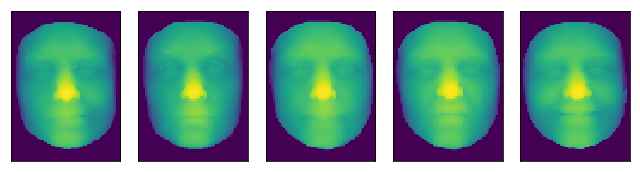

In [10]:
# Visualize the face data before resizing and downsampling
data_utils.visualize_z(face_data, z_channel=2)

In [6]:
# Resize and downsample the images to 80 x 60 from 280, 210
face_data = resize(face_data, (face_data.shape[0], 264, 192, face_data.shape[3]), preserve_range=True, mode="constant", anti_aliasing=True)
face_data = block_reduce(face_data, block_size=(1, 3, 3, 1), func=np.max)

In [7]:
np.save("final_data", face_data)
np.save("final_mark", landmarks)

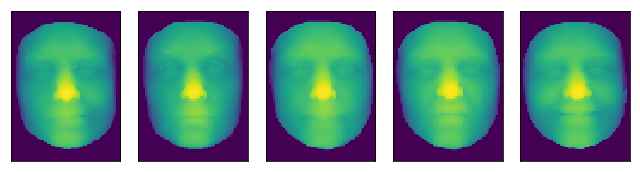

In [9]:
# Visualize the face data after resizing and downsampling
data_utils.visualize_z(face_data, z_channel=2)

## Train the model

In [32]:
importlib.reload(data_utils);
importlib.reload(CGAN);

In [44]:
class Params:

    drop_rate = 0.4
    n_filters = 32
    n_rand = 100
    batch_size = 32
    train_steps = 500
    interval = 1
    lr_D =  0.0001
    lr_GD = 0.0005
    
    def __init__(self, X, X_cond=None):
        _, self.W, self.H, self.n_channels = X.shape
        _, self.n_cond = X_cond.shape if X_cond else (None, 0)

In [45]:
X = face_data[:, :, :, 2:3]
network = CGAN.CGAN(Params(X))

Step 1:



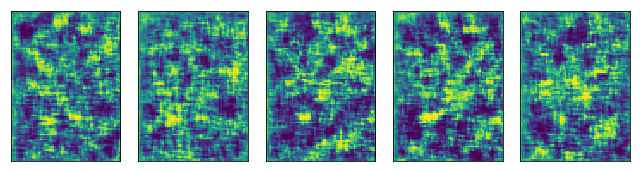


Descriminator :: loss = 0.9062998294830322, acc = 0.5
Adversarial   :: loss = 0.6586502194404602, acc = 0.6470588445663452
Step 2:



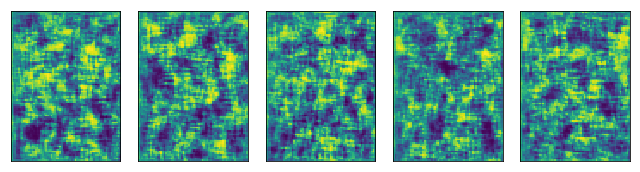


Descriminator :: loss = 0.5405964851379395, acc = 0.8970588445663452
Adversarial   :: loss = 1.0514836311340332, acc = 0.14705882966518402
Step 3:



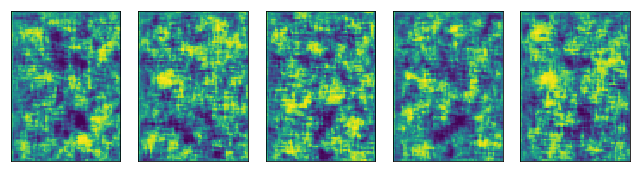


Descriminator :: loss = 0.5225685238838196, acc = 0.9117646813392639
Adversarial   :: loss = 1.4997453689575195, acc = 0.029411764815449715
Step 4:



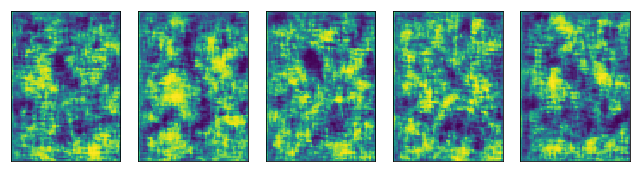


Descriminator :: loss = 0.4215502142906189, acc = 1.0
Adversarial   :: loss = 1.716403841972351, acc = 0.0
Step 5:



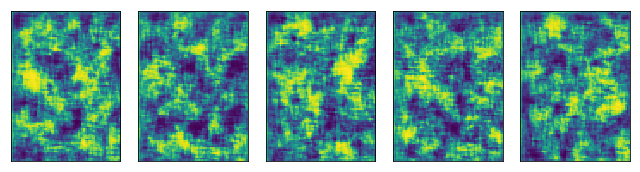


Descriminator :: loss = 0.3758188486099243, acc = 1.0
Adversarial   :: loss = 2.107002019882202, acc = 0.0
Step 6:



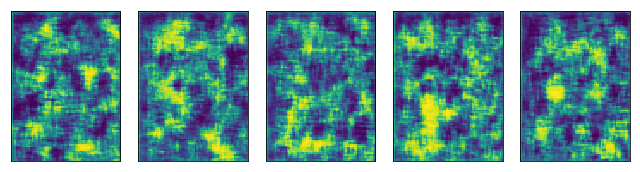


Descriminator :: loss = 0.2684805989265442, acc = 1.0
Adversarial   :: loss = 2.156904935836792, acc = 0.0
Step 7:



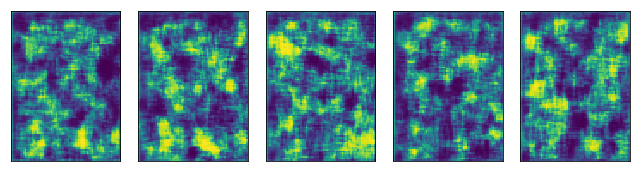


Descriminator :: loss = 0.19424329698085785, acc = 1.0
Adversarial   :: loss = 1.9786100387573242, acc = 0.0
Step 8:



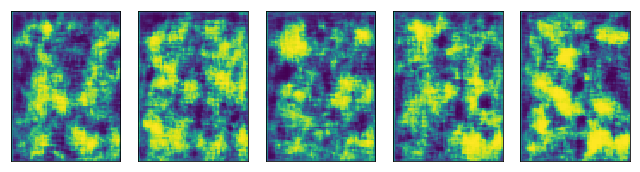


Descriminator :: loss = 0.2014336735010147, acc = 1.0
Adversarial   :: loss = 2.3720922470092773, acc = 0.0
Step 9:



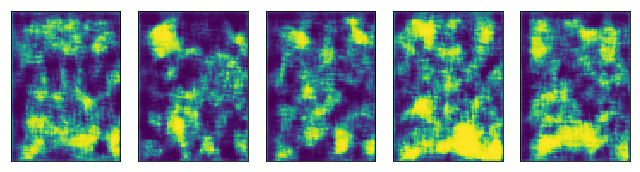


Descriminator :: loss = 0.14376075565814972, acc = 1.0
Adversarial   :: loss = 2.296722173690796, acc = 0.0
Step 10:



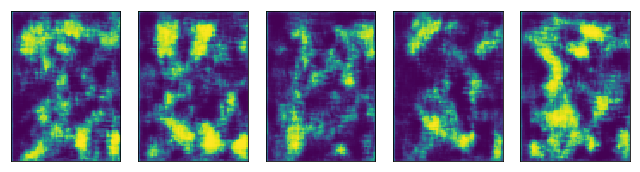


Descriminator :: loss = 0.09036567807197571, acc = 1.0
Adversarial   :: loss = 2.0791351795196533, acc = 0.0
Step 11:



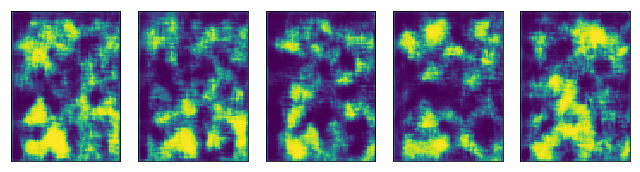


Descriminator :: loss = 0.107056625187397, acc = 1.0
Adversarial   :: loss = 2.212251663208008, acc = 0.0
Step 12:



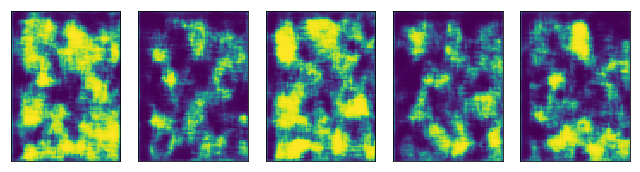


Descriminator :: loss = 0.08427360653877258, acc = 1.0
Adversarial   :: loss = 2.406684160232544, acc = 0.0
Step 13:



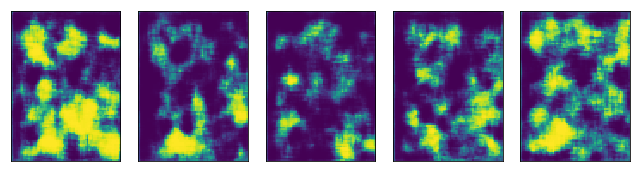


Descriminator :: loss = 0.0568406768143177, acc = 1.0
Adversarial   :: loss = 2.2524356842041016, acc = 0.029411764815449715
Step 14:



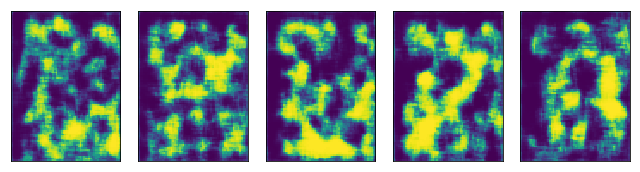


Descriminator :: loss = 0.05095388740301132, acc = 1.0
Adversarial   :: loss = 2.3139243125915527, acc = 0.029411764815449715
Step 15:



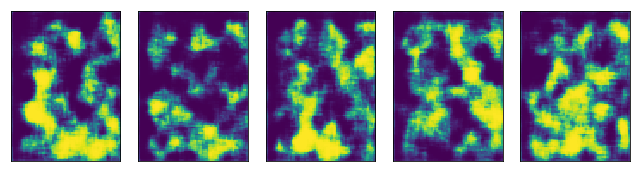


Descriminator :: loss = 0.07934576272964478, acc = 1.0
Adversarial   :: loss = 2.6760759353637695, acc = 0.0
Step 16:



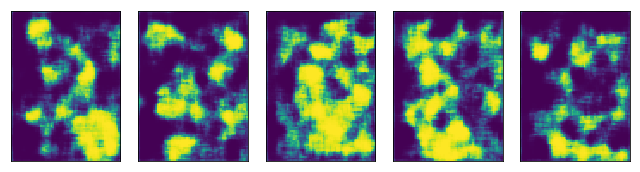


Descriminator :: loss = 0.06215805932879448, acc = 1.0
Adversarial   :: loss = 2.808896064758301, acc = 0.029411764815449715
Step 17:



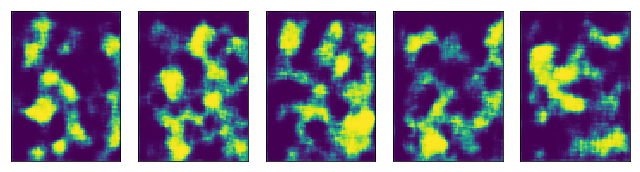


Descriminator :: loss = 0.030443251132965088, acc = 1.0
Adversarial   :: loss = 2.4625113010406494, acc = 0.0
Step 18:



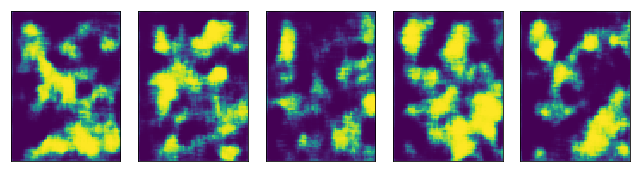


Descriminator :: loss = 0.03158905357122421, acc = 1.0
Adversarial   :: loss = 2.690506935119629, acc = 0.0
Step 19:



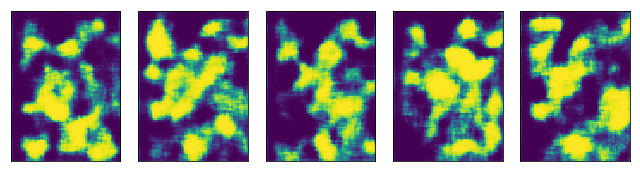


Descriminator :: loss = 0.05336776003241539, acc = 0.9852941036224365
Adversarial   :: loss = 2.946462631225586, acc = 0.0
Step 20:



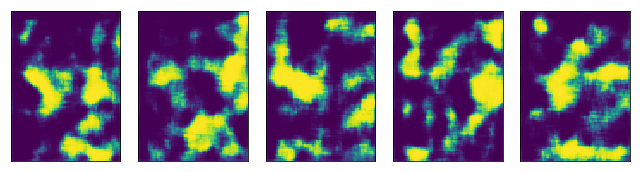


Descriminator :: loss = 0.022719694301486015, acc = 1.0
Adversarial   :: loss = 2.815004825592041, acc = 0.029411764815449715
Step 21:



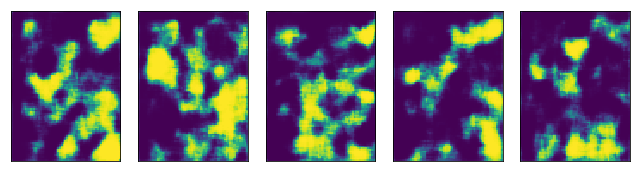


Descriminator :: loss = 0.03011169098317623, acc = 1.0
Adversarial   :: loss = 2.9366984367370605, acc = 0.029411764815449715
Step 22:



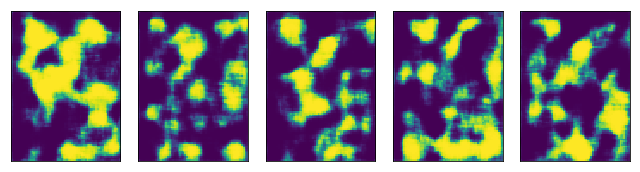


Descriminator :: loss = 0.03161105513572693, acc = 1.0
Adversarial   :: loss = 3.377835750579834, acc = 0.0
Step 23:



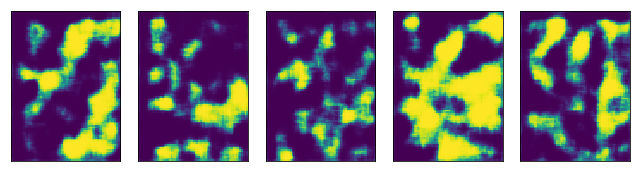


Descriminator :: loss = 0.028340041637420654, acc = 1.0
Adversarial   :: loss = 3.313638687133789, acc = 0.0
Step 24:



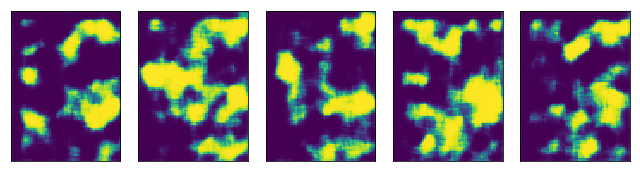


Descriminator :: loss = 0.022209739312529564, acc = 1.0
Adversarial   :: loss = 3.3278985023498535, acc = 0.0
Step 25:



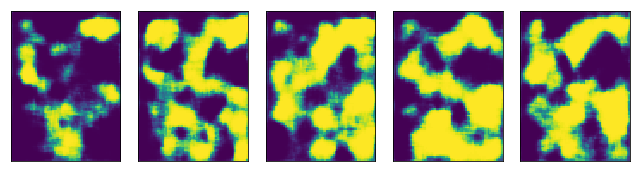


Descriminator :: loss = 0.1099850982427597, acc = 0.9558823704719543
Adversarial   :: loss = 4.906375885009766, acc = 0.0
Step 26:



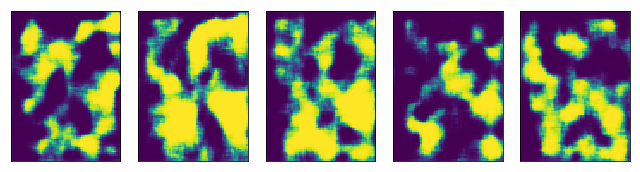


Descriminator :: loss = 0.051340337842702866, acc = 0.9852941036224365
Adversarial   :: loss = 5.01317024230957, acc = 0.0
Step 27:



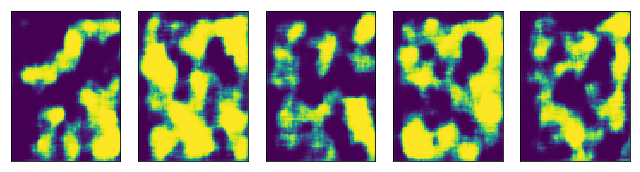


Descriminator :: loss = 0.05542810633778572, acc = 1.0
Adversarial   :: loss = 5.753746032714844, acc = 0.0
Step 28:



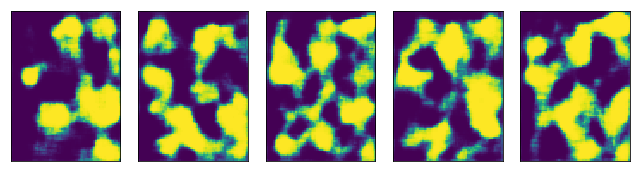


Descriminator :: loss = 0.026963461190462112, acc = 1.0
Adversarial   :: loss = 5.533776760101318, acc = 0.0
Step 29:



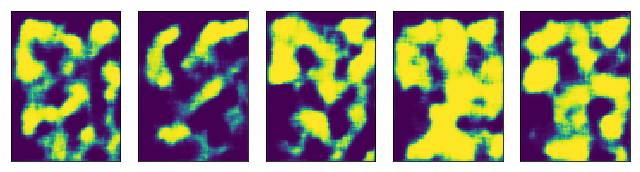


Descriminator :: loss = 0.060621824115514755, acc = 1.0
Adversarial   :: loss = 6.418501377105713, acc = 0.0
Step 30:



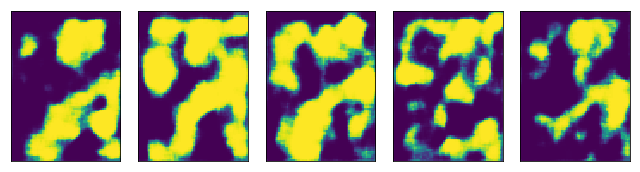


Descriminator :: loss = 0.03175954148173332, acc = 1.0
Adversarial   :: loss = 6.3116455078125, acc = 0.0
Step 31:



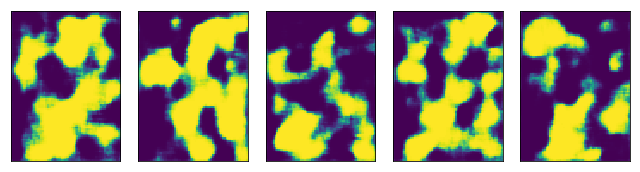


Descriminator :: loss = 0.021668847650289536, acc = 1.0
Adversarial   :: loss = 6.1472344398498535, acc = 0.0
Step 32:



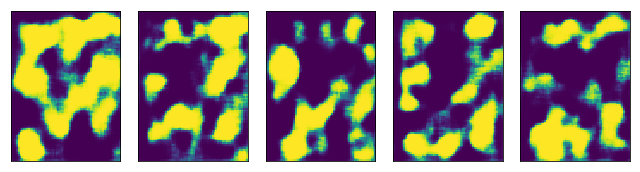


Descriminator :: loss = 0.018601035699248314, acc = 1.0
Adversarial   :: loss = 5.937505722045898, acc = 0.0
Step 33:



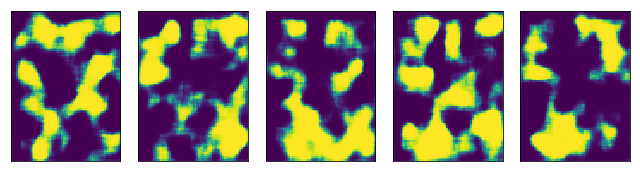


Descriminator :: loss = 0.012981469742953777, acc = 1.0
Adversarial   :: loss = 5.7737298011779785, acc = 0.0
Step 34:



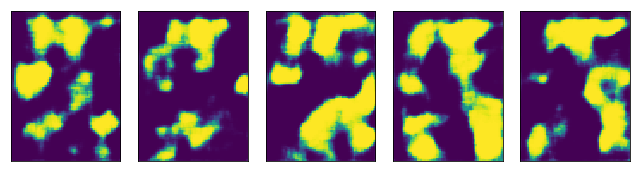


Descriminator :: loss = 0.008972558192908764, acc = 1.0
Adversarial   :: loss = 5.745828151702881, acc = 0.0
Step 35:



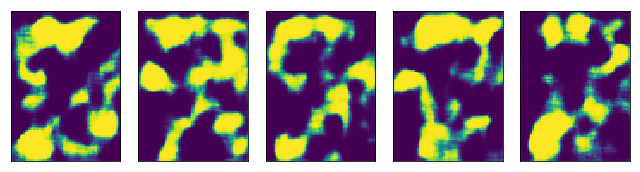


Descriminator :: loss = 0.009045046754181385, acc = 1.0
Adversarial   :: loss = 5.549080848693848, acc = 0.0
Step 36:



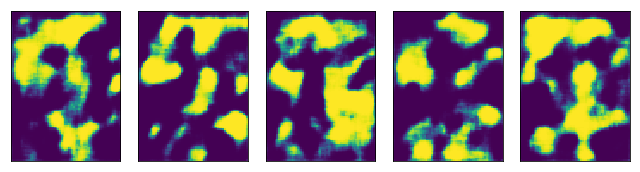


Descriminator :: loss = 0.007225369568914175, acc = 1.0
Adversarial   :: loss = 5.602458477020264, acc = 0.0
Step 37:



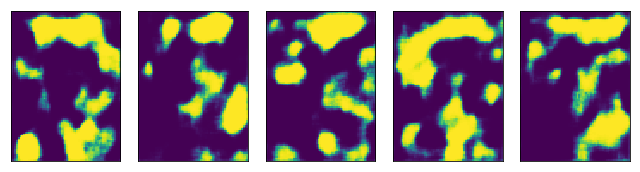


Descriminator :: loss = 0.006384025793522596, acc = 1.0
Adversarial   :: loss = 5.301043510437012, acc = 0.0
Step 38:



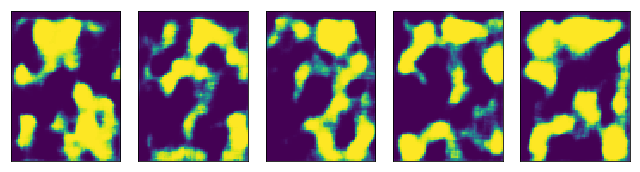


Descriminator :: loss = 0.005766680464148521, acc = 1.0
Adversarial   :: loss = 5.345093727111816, acc = 0.029411764815449715
Step 39:



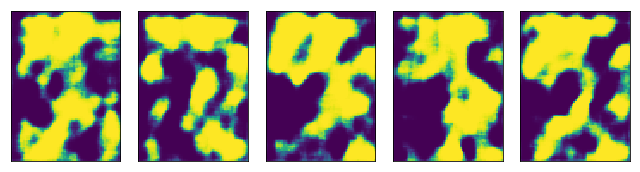


Descriminator :: loss = 0.02507590688765049, acc = 1.0
Adversarial   :: loss = 5.917274475097656, acc = 0.0


KeyboardInterrupt: 

In [46]:
for step in range(Params.train_steps):
    X_real = X[np.random.randint(X.shape[0], size=(Params.batch_size)), :, : :]
    X_fake = network.G.predict(np.random.uniform(size=(Params.batch_size, Params.n_rand)))
    X_D = np.concatenate((X_real, X_fake))
    Y_D = np.concatenate((np.ones((X_real.shape[0], 1)), np.zeros((X_fake.shape[0], 1))))
    loss_D, acc_D = network.D.train_on_batch(X_D, Y_D)
    
    for i in range(1):
        X_GD = np.random.uniform(size=(Params.batch_size, Params.n_rand))
        Y_GD = np.ones((X_GD.shape[0], 1))
        loss_GD, acc_GD = network.GD.train_on_batch(X_GD, Y_GD)
    
    if step % Params.interval == 0 and step > 0:
        print("Step {}:".format(step))
        print()
        data_utils.visualize_z(X_fake)
        print()
        print("Descriminator :: loss = {}, acc = {}".format(loss_D, acc_D))
        print("Adversarial   :: loss = {}, acc = {}".format(loss_GD, acc_GD))